# MEG Exercise

In [1]:
from os import path
from collections import defaultdict

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

import mne
from mne.preprocessing import maxwell_filter

#%matplotlib notebook
%matplotlib inline

# to see less log information, by default, mne is pretty verbose
mne.set_log_level('warning')

In [2]:
data_path = '/home/okozyn/Projects/inria/meg_exercise/data'

subjects = ['CC320359', 'CC620085', 'CC721504']
states = ['passive', 'rest', 'task']
bad_channels = {key: defaultdict(list) for key in subjects}

bad_channels['CC320359']['passive'] = ['MEG0733']
bad_channels['CC721504']['passive'] = ['MEG0612', 'MEG2442']

sel_subject = subjects[2]
sel_state = states[0]

raw_fname = path.join(data_path, f'{sel_subject}/{sel_state}/{sel_state}_raw.fif')
raw_empty_room_path = path.join(data_path, f'{sel_subject}/emptyroom_{sel_subject}.fif')
cross_talk_corr_info_path = path.join(data_path, 'ct_sparse.fif')
calib_path = path.join(data_path, 'sss_cal.dat')


raw = mne.io.read_raw_fif(raw_fname)
raw_empty_room = mne.io.read_raw_fif(raw_empty_room_path)

<ipython-input-2-19cc1850c0fe>:20: RuntimeWarning: This filename (/home/okozyn/Projects/inria/meg_exercise/data/CC721504/emptyroom_CC721504.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_empty_room = mne.io.read_raw_fif(raw_empty_room_path)


In [3]:
bad_channels

{'CC320359': defaultdict(list, {'passive': ['MEG0733']}),
 'CC620085': defaultdict(list, {}),
 'CC721504': defaultdict(list, {'passive': ['MEG0612', 'MEG2442']})}

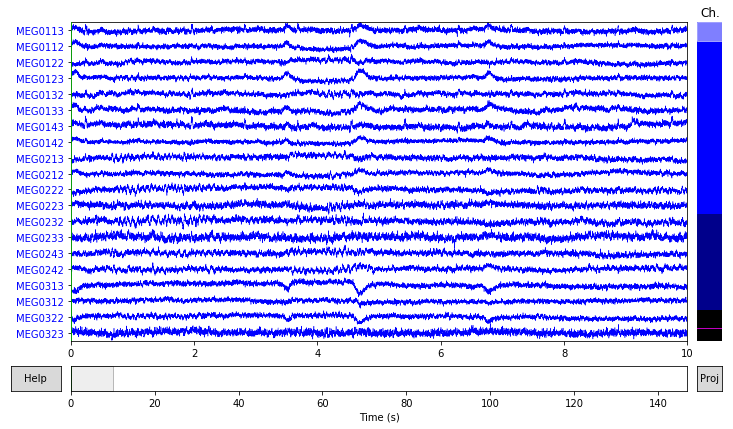

In [4]:
_ = raw.plot(group_by='type')

## Maxwell Filtering

In [5]:
raw.info['bads'] = bad_channels[sel_subject][sel_state]
raw_sss = maxwell_filter(raw, cross_talk=cross_talk_corr_info_path, calibration=calib_path)

<ipython-input-5-967b1539439a>:2: RuntimeWarning: 102 T1/T2 magnetometer channel types found. If using SSS, it is advised to replace coil types using "fix_mag_coil_types".
  raw_sss = maxwell_filter(raw, cross_talk=cross_talk_corr_info_path, calibration=calib_path)


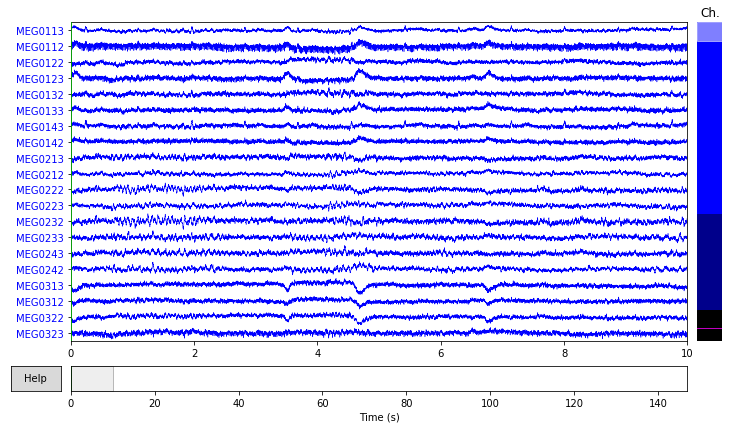

In [6]:
_ = raw_sss.plot(group_by='type')

## Bandpass Filtering

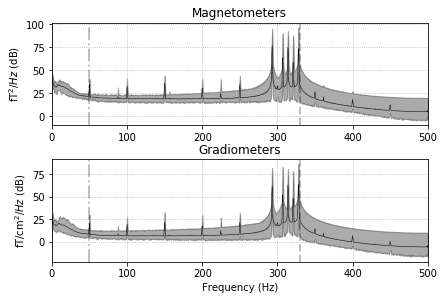

In [7]:
# PSD - power spectral density
_ = raw_sss.plot_psd(area_mode='range', show=False, average=True)

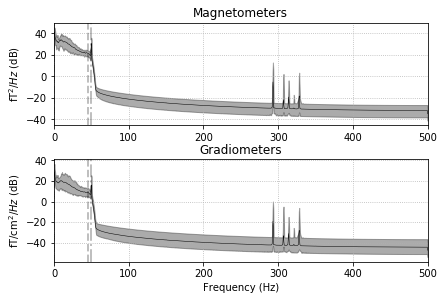

In [8]:
# filtering is done in-place
# Maxwell filter works as high-pass filter with the cut-off frequency of 0.1 Hz
# To choose between low-, high-, or band-pass we need to 
# l_freq < h_freq: band-pass filter
# l_freq > h_freq: band-stop filter
# l_freq is not None and h_freq is None: high-pass filter
# l_freq is None and h_freq is not None: low-pass filter

# h_freq value was taken from David's report
raw_sss.filter(0.4, 45)

_ = raw_sss.plot_psd(area_mode='range', show=False, average=True)

## Epoch rejection

In MNE, epoch refers to a collection of single trials or short segments of time locked raw data. STI stands for stimulus channel.
[Tutorial Link](https://martinos.org/mne/dev/auto_tutorials/plot_epoching_and_averaging.html?highlight=epoch%20rejection)

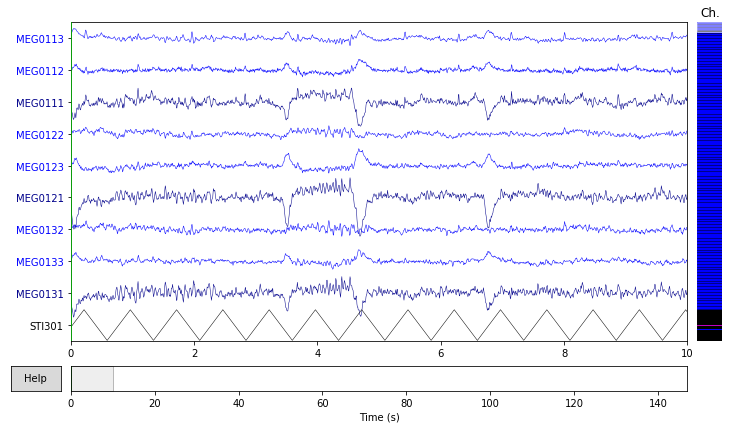

In [9]:
order = np.arange(raw.info['nchan'])
# We exchange the plotting order of two channels
# to show the trigger channel as the 10th channel.
order[9] = 326
order[326] = 9

_ = raw_sss.plot(n_channels=10, order=order)

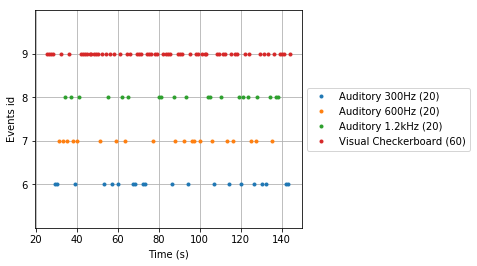

[[88357     0     9]
 [89357     0     9]
 [90224     0     9]
 [91208     0     9]
 [92208     0     6]]


In [10]:
event_id = {'Auditory 300Hz': 6, 'Auditory 600Hz': 7,
             'Auditory 1.2kHz': 8, 'Visual Checkerboard': 9}
event_id_tup = tuple(event_id.keys())
# STI301 gives some periodic stimulus
events = mne.find_events(raw_sss)

_ = mne.viz.plot_events(events, raw_sss.info['sfreq'], raw_sss.first_samp, event_id = event_id)
print(events[:5, :])

The event list contains three columns. The first column corresponds to **sample number**. To convert this to seconds, you should divide the sample number by the used sampling frequency. The second column is reserved for the old value of the trigger channel at the time of transition, but is currently not in use. The third column is the **trigger id** (amplitude of the pulse).


This is because Neuromag recordings have an attribute **first_samp** which refers to the offset between the system start and the start of the recording. Our data has a first_samp equal to 25800. This means that the first sample you see with raw.plot is the sample number 25800.

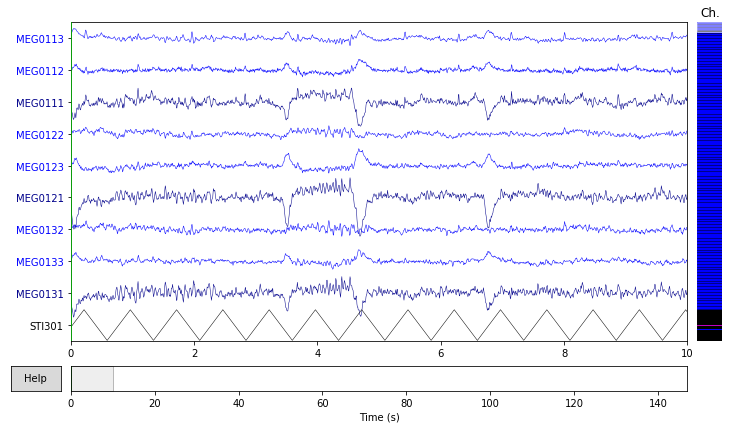

In [11]:
_ = raw_sss.plot(events=events, n_channels=10, order=order)

In [12]:
# epoch time-range in seconds
tmin, tmax = -0.2, 0.5
picks = mne.pick_types(raw_sss.info, meg=True, eeg=False, eog=True)

baseline = (None, 0.0)
reject = {'mag': 4e-12, 'eog': 200e-6}
epochs = mne.Epochs(raw_sss, events=events, event_id=event_id, tmin=tmin,
                    tmax=tmax, baseline=baseline, reject=reject, picks=picks)

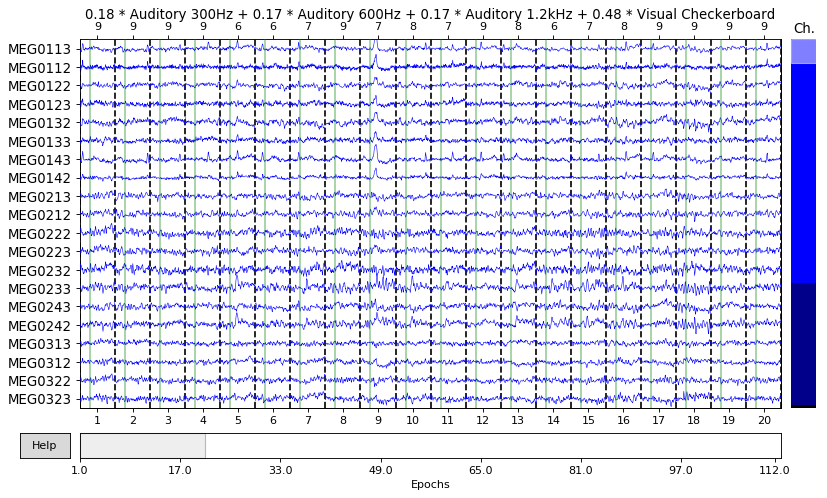

In [13]:
_ = epochs.plot(block=True)

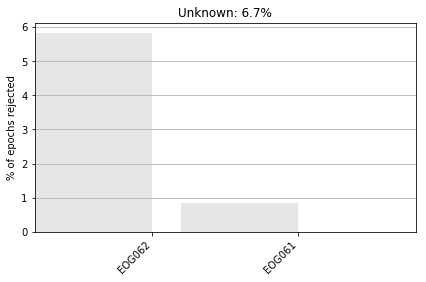

In [14]:
_ = epochs.plot_drop_log()

## Evoked Responses

In [15]:
picks = mne.pick_types(epochs.info, meg=True, eog=True)

evoked_1 = epochs[event_id_tup[0]].average(picks=picks) # ???
evoked_2 = epochs[event_id_tup[-1]].average(picks=picks)

### Evoked Response for the 300Hz Auditory Stimulus

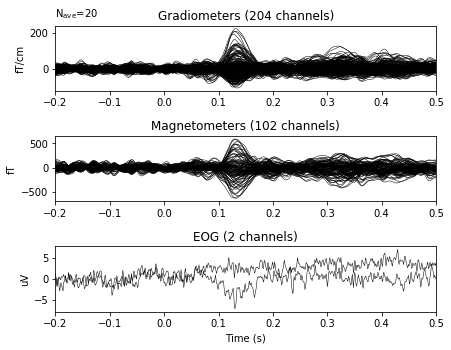

In [16]:
_ = evoked_1.plot(time_unit='s')

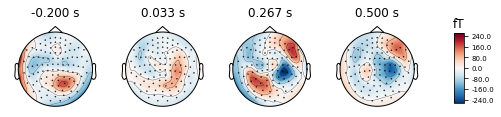

In [17]:
# parameter are from tutorial
# https://martinos.org/mne/stable/auto_examples/visualization/plot_evoked_topomap.html

_ = evoked_1.plot_topomap(ch_type='mag', time_unit='s')

### Evoked Responses for the Visual Checkerboard Stimulus

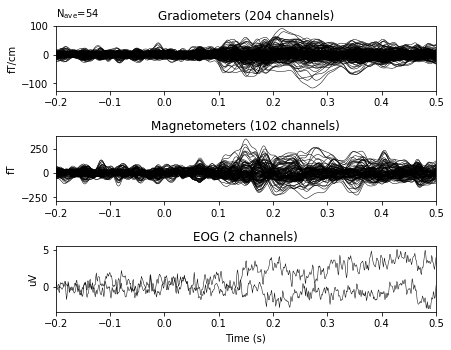

In [18]:
_ = evoked_2.plot(time_unit='s')

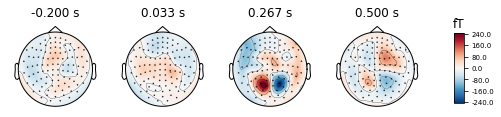

In [19]:
_ = evoked_2.plot_topomap(ch_type='mag', time_unit='s')

## Covariance Matrix

Use pre-stimulus baseline to get noise covariance matrix.
[Whitening Example](https://mne-tools.github.io/0.12/auto_examples/visualization/plot_evoked_whitening.html)

In [20]:
noise_cov_baseline = mne.compute_covariance(epochs, tmax=0, method='empirical', return_estimators=True)
# _ = noise_cov_baseline.plot(epochs.info, proj=True)

print('Covariance estimates sorted from the best to worst')
# for c in noise_cov_baseline:
#     print("%s : %s" % (c['method'], c['loglik']))

Covariance estimates sorted from the best to worst


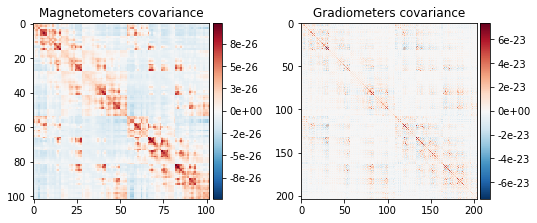

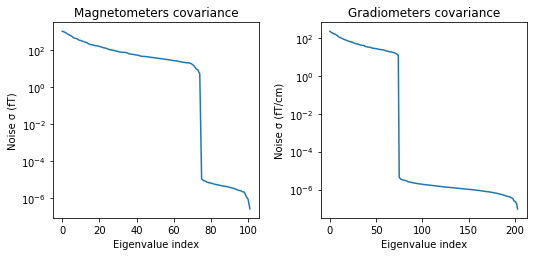

In [21]:
_ = noise_cov_baseline.plot(epochs.info, proj=True)

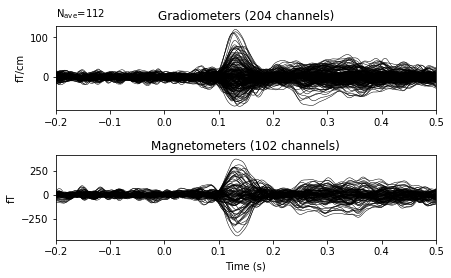

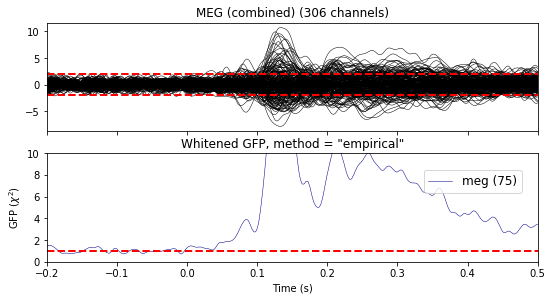

In [22]:
evoked_total = epochs.average()
_ = evoked_total.plot()
# plot the whitened evoked data for to see if baseline signals match the
# assumption of Gaussian white noise from which we expect values around
# 0 with less than 2 standard deviations. For the Global field power we expect
# a value of 1.
_ = evoked_total.plot_white(noise_cov_baseline)

## Empty Room Noise Covariance 

In [23]:
raw_empty_room.info['bads'] = bad_channels[sel_subject][sel_state]
raw_empty_room_sss = maxwell_filter(raw_empty_room, cross_talk=cross_talk_corr_info_path,
                                    calibration=calib_path, coord_frame='meg')
raw_sss = raw_sss.filter(0.4, 45)

<ipython-input-23-db2f2819bad5>:3: RuntimeWarning: 102 T1/T2 magnetometer channel types found. If using SSS, it is advised to replace coil types using "fix_mag_coil_types".
  calibration=calib_path, coord_frame='meg')


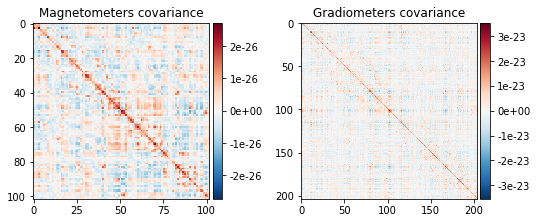

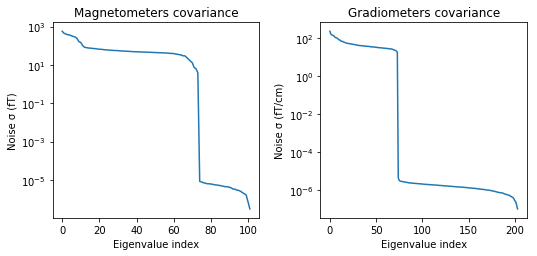

In [24]:
noise_cov_empty_room = mne.compute_raw_covariance(raw_empty_room_sss, tmin=0, tmax=None, method='empirical', return_estimators=False)
_ = noise_cov_empty_room.plot(raw_empty_room.info, proj=True)

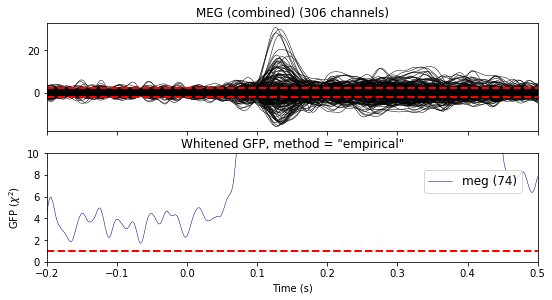

In [25]:
# empty room recordings give me an error
_ = evoked_total.plot_white(noise_cov_empty_room)

## Co-registration

In [26]:
# to launch a program
# mne coreg -s CC721504 -d /home/okozyn/Projects/inria/meg_exercise/data/freesurfer --trans /home/okozyn/Projects/inria/meg_exercise/data/trans/sub-CC721504-trans.fif
subjects_dir = '../data/freesurfer'
trans = f'../data/{sel_subject}/passive/{sel_subject}-trans.fif'

#mne.viz.plot_alignment(raw_sss.info, trans=trans, subject=subject, subjects_dir=subjects_dir)

## dSPM
BEM calculations failed for subject CC320359

In [27]:
# create forward operator
# which spacing should I take and why?

sphere = (0, 0, 0, 120)
# Left_Cerebral_Cortex 3, Right_Cerebral_Cortex 42
volume_labels = ['Left-Cerebral-Cortex', 'Right-Cerebral-Cortex']
mri_aseg_path = f'../data/freesurfer/{sel_subject}/mri/aseg.mgz'

# src = mne.setup_source_space(subject=sel_subject, subjects_dir=subjects_dir) #spacing='ico4',
# src = mne.setup_volume_source_space(subject=sel_subject, subjects_dir=subjects_dir, volume_label=volume_labels, 
#                                    sphere=sphere, mri=mri_aseg_path)
src = mne.setup_volume_source_space(subject=sel_subject, subjects_dir=subjects_dir, mri=mri_aseg_path,
                                   volume_label=volume_labels,)


bem_model = mne.make_bem_model(subject=sel_subject, subjects_dir=subjects_dir) #ico=4
bem = mne.make_bem_solution(bem_model)

fwd = mne.make_forward_solution(raw_sss.info, trans, src, bem)

In [28]:
# create inverse operator
from mne.minimum_norm import make_inverse_operator, apply_inverse

inv_noise_baseline = make_inverse_operator(raw_sss.info, fwd, noise_cov_baseline, loose=1)
inv_noise_empty_room = make_inverse_operator(raw_sss.info, fwd, noise_cov_empty_room, loose=1)

/home/okozyn/anaconda3/envs/mne/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


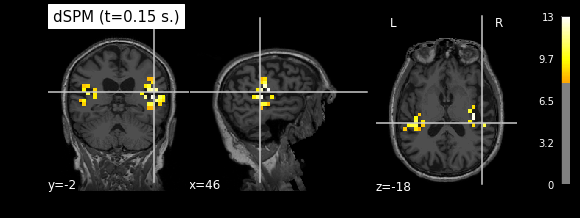

In [29]:
from nilearn.plotting import plot_stat_map
from nilearn.image import index_img

snr = 3.0
lambda2 = 1.0 / snr ** 2
method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)

# src = inv_noise_baseline['src']

# Compute inverse solution
stc = apply_inverse(evoked_total, inv_noise_baseline, lambda2, method)
stc.crop(0.0, 0.2)

# plots of surface results
# _ = stc.plot(subjects_dir=subjects_dir, initial_time=0.26, hemi='lh',
#              backend='matplotlib', verbose='error')

# _ = stc.plot(subjects_dir=subjects_dir, initial_time=0.26, hemi='rh',
#              backend='matplotlib', verbose='error')

# Export result as a 4D nifti object
img = stc.as_volume(src,
                    mri_resolution=False)  # set True for full MRI resolution

# Save it as a nifti file
# nib.save(img, '%s-%s_inverse-noise_base.nii.gz' % (sel_subject, method))

t1_fname = f'../data/freesurfer/{sel_subject}/mri/T1.mgz'

# Plotting with nilearn ######################################################
plot_stat_map(index_img(img, 150), t1_fname, threshold=8.,
              title='%s (t=%.2f s.)' % (method, stc.times[150]))
plt.show()

/home/okozyn/anaconda3/envs/mne/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


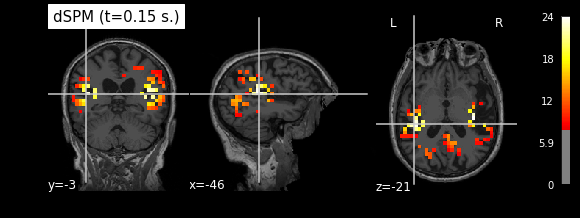

In [30]:
# Compute inverse solution
stc = apply_inverse(evoked_total, inv_noise_empty_room, lambda2, method)
stc.crop(0.0, 0.2)

# Export result as a 4D nifti object
img = stc.as_volume(src,
                    mri_resolution=False)  # set True for full MRI resolution

# Save it as a nifti file
# nib.save(img, '%s-%s_inverse-noise_eroom.nii.gz' % (sel_subject, method))

t1_fname = f'../data/freesurfer/{sel_subject}/mri/T1.mgz'

# Plotting with nilearn ######################################################
plot_stat_map(index_img(img, 150), t1_fname, threshold=8.,
              title='%s (t=%.2f s.)' % (method, stc.times[150]))
plt.show()

## Independent Component Analysis (ICA)

In [31]:
from mne.preprocessing import ICA, create_ecg_epochs, create_eog_epochs

reject = dict(mag=5e-12, grad=4000e-13)

ica = ICA(n_components=0.95, method='fastica', random_state=0, max_iter=100)
picks_ica = mne.pick_types(raw_sss.info, meg=True, eeg=False, eog=False, stim=False, exclude='bads')

ica.fit(raw_sss, picks=picks_ica, decim=3, reject=reject)

<ICA  |  raw data decomposition, fit (fastica): 47357 samples, 34 components, channels used: "mag"; "grad">

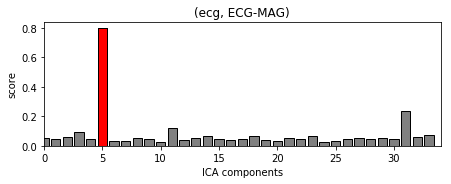

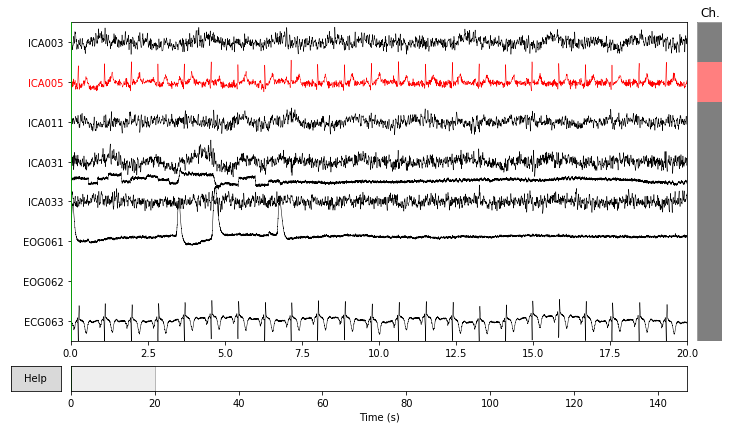

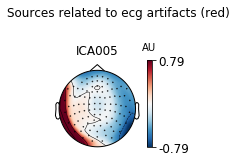

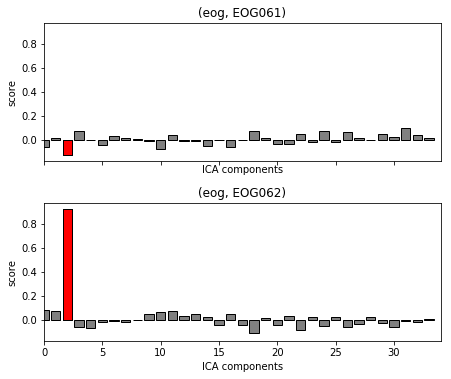

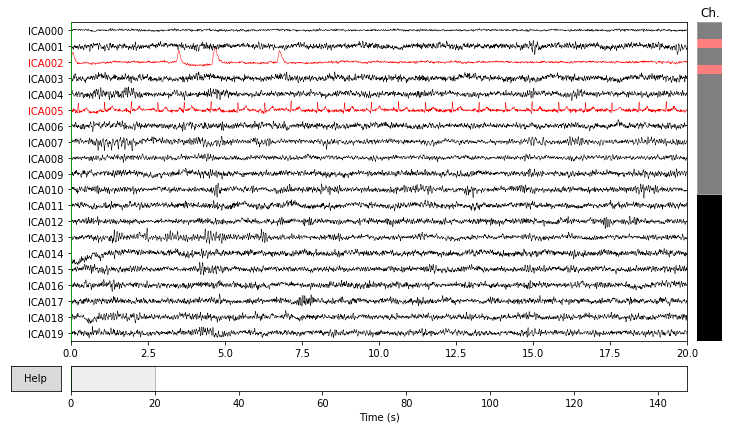

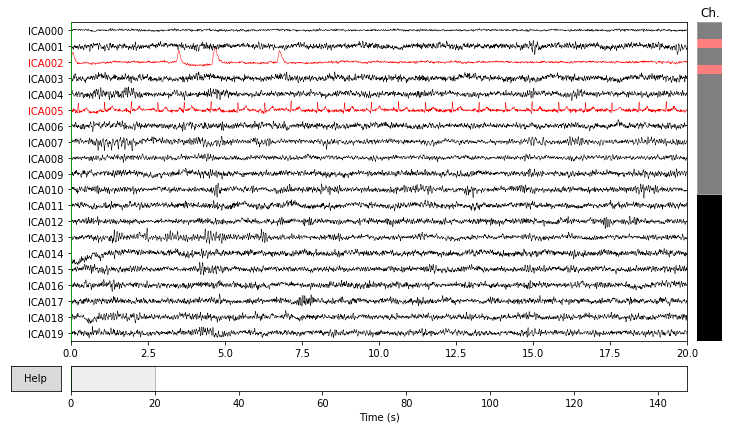

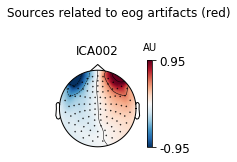

In [32]:
# maximum number of components to reject
n_max_ecg, n_max_eog = 3, 2
title = 'Sources related to %s artifacts (red)'

ecg_epochs = create_ecg_epochs(raw_sss, tmin=-0.5, tmax=0.5, picks=picks_ica)

ecg_inds, scores = ica.find_bads_ecg(ecg_epochs, method='ctps')
_ = ica.plot_scores(scores, exclude=ecg_inds, title=title % 'ecg', labels='ecg')

show_picks = np.abs(scores).argsort()[::-1][:5]

_ = ica.plot_sources(raw_sss, show_picks, exclude=ecg_inds, title=title % 'ecg')
_ = ica.plot_components(ecg_inds, title=title % 'ecg', colorbar=True)

ecg_inds = ecg_inds[:n_max_ecg]
# to definitely register this component as a bad one to be removed
# there is the ``ica.exclude`` attribute, a simple Python list
ica.exclude += ecg_inds

# detect EOG by correlation
eog_inds, scores = ica.find_bads_eog(raw_sss)
_ = ica.plot_scores(scores, exclude=eog_inds, title=title % 'eog', labels='eog')

# I had an error here, because in the next plot funtion if couldn't understand why 
# do I have array that consists of two arrays
# maybe it was because I have two EOG channels and only one ECG channel
show_picks  = np.abs(scores).argsort()[::-1][:5]

_ = ica.plot_sources(raw_sss, show_picks[0], exclude=eog_inds, title=title % 'eog 1')
_ = ica.plot_sources(raw_sss, show_picks[1], exclude=eog_inds, title=title % 'eog 2')
_ = ica.plot_components(eog_inds, title=title % 'eog', colorbar=True)

eog_inds = eog_inds[:n_max_eog]
# to definitely register this component as a bad one to be removed
# there is the ``ica.exclude`` attribute, a simple Python list
ica.exclude += eog_inds

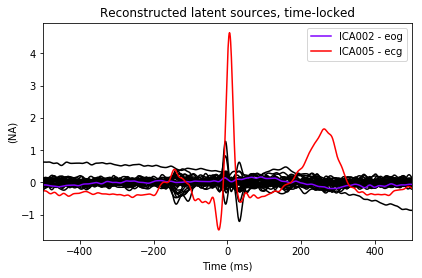

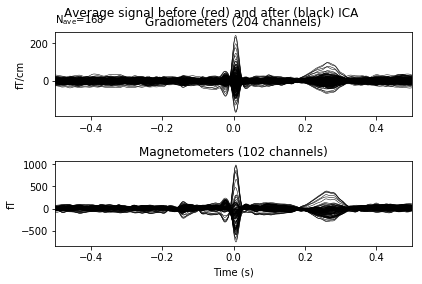

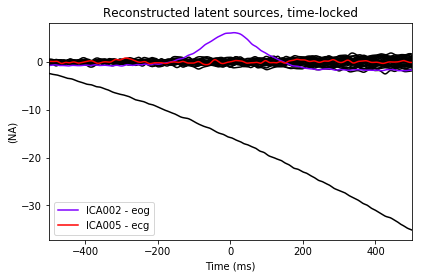

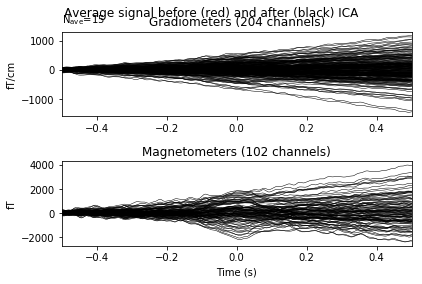

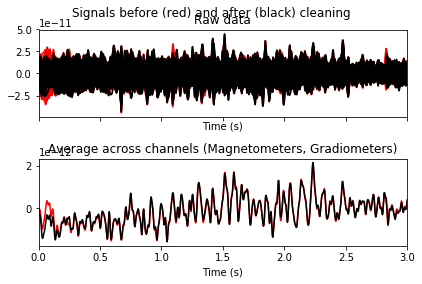

In [33]:
# estimate average artifact
ecg_evoked = ecg_epochs.average()
_ = ica.plot_sources(ecg_evoked, exclude=ecg_inds)  # plot ECG sources + selection
_ = ica.plot_overlay(ecg_evoked, exclude=ecg_inds)  # plot ECG cleaning

eog_evoked = create_eog_epochs(raw_sss, tmin=-.5, tmax=.5, picks=picks).average()
_ = ica.plot_sources(eog_evoked, exclude=eog_inds)  # plot EOG sources + selection
_ = ica.plot_overlay(eog_evoked, exclude=eog_inds)  # plot EOG cleaning

# check the amplitudes do not change
_ = ica.plot_overlay(raw_sss)  # EOG artifacts remain

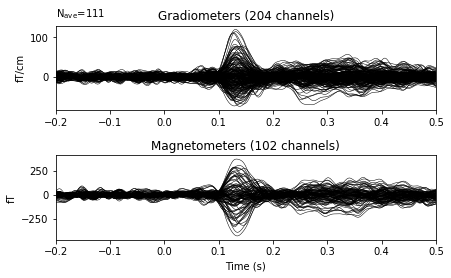

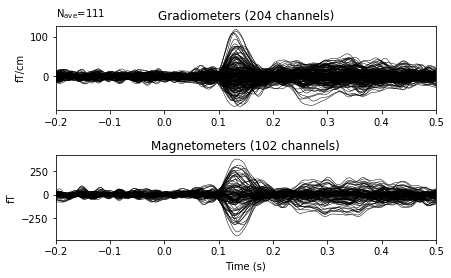

214506


In [34]:
# Apply the solution to Raw, Epochs or Evoked like this:
evoked_total = epochs.average()
_ = evoked_total.plot()

evoked_total_ecg_eog = evoked_total.copy()

ica.apply(evoked_total_ecg_eog)

_ = evoked_total_ecg_eog.plot()

print(np.sum(np.abs(evoked_total_ecg_eog.data - evoked_total.data) > 0))